In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import pandas as pd
from dw_events.temperature_compensation.kalman_filter import KalmanFilter1D
from dw_events.data.make_dataset import DataGetter
from dw_events.data.utils import make_dt_list, get_dataframe_str_subset
import datetime
import matplotlib.pyplot as plt

In [3]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2022, 9, 2)
data_path = \
    "_".join(
        [
            "../data/raw/strain_data",
            str(start.year),
            str(start.month),
            str(start.day),
            str(end.year),
            str(end.month),
            str(end.day),
            ".parquet"
        ]
    )
datagetter = DataGetter(start, end)
try:
    strain_data = pd.read_parquet(data_path)
    datagetter.merged_signals = strain_data
except:
    strain_data = datagetter.get_strain_data()
    strain_data.to_parquet(data_path)

ArrowNotImplementedError: Support for codec 'snappy' not built

In [8]:
# Get strain line data BCN
BCN_signals = datagetter.get_dataframe_str_subset('BCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
bottom_temperature_data = temperature_data.filter(regex="_B")

In [10]:
bottom_temperature_data

,SCB_ALM_BCS_TFBG_HOR002
time,
2022-08-31 22:00:00+00:00,16.2
2022-08-31 22:00:00.050000+00:00,16.3
2022-08-31 22:00:00.100000+00:00,16.2
2022-08-31 22:00:00.150000+00:00,16.2
2022-08-31 22:00:00.200000+00:00,16.2
...,...
2022-09-01 21:59:59.750000+00:00,17.3
2022-09-01 21:59:59.800000+00:00,17.3
2022-09-01 21:59:59.850000+00:00,17.3


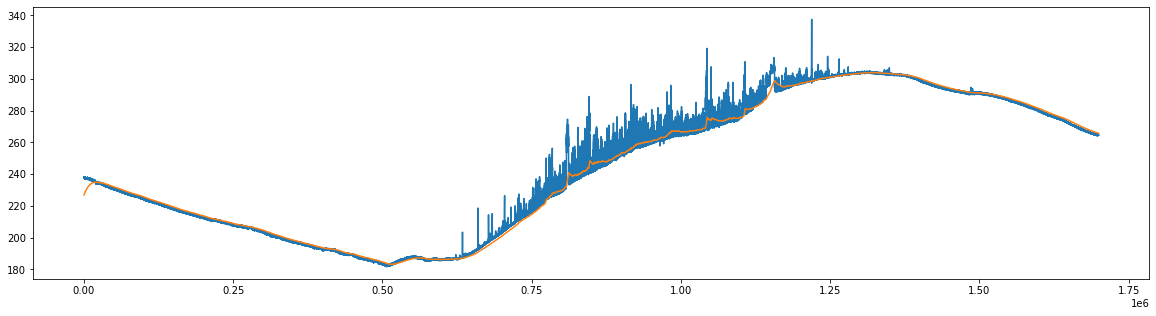

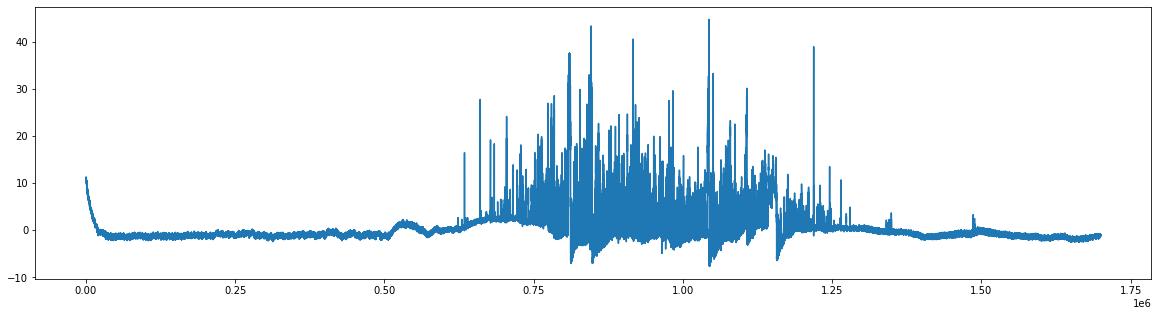

In [11]:
start = 0
stop = 5000000
process_variance = 1e-4
estimated_measurement_variance = 10000

kf = \
    KalmanFilter1D(
        process_variance,
        estimated_measurement_variance
    )
series = []
for idx, row in BCN_signals.iloc[start:stop,3:4].iterrows():
    kf.input_latest_noisy_measurement(row[0])
    series.append(kf.get_latest_estimated_measurement())

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 30000
plt.plot(BCN_signals.iloc[start+start_series:stop,3].values)
plt.plot(series[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(BCN_signals.iloc[start+start_series:stop,3].values - series[start_series:])
plt.show()

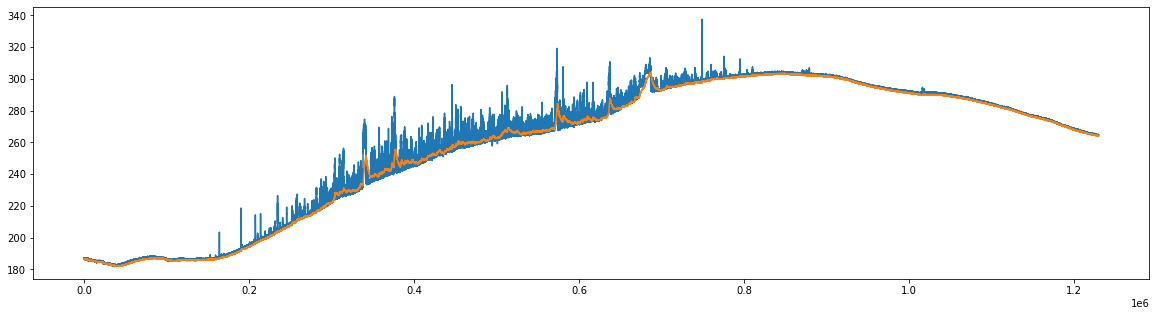

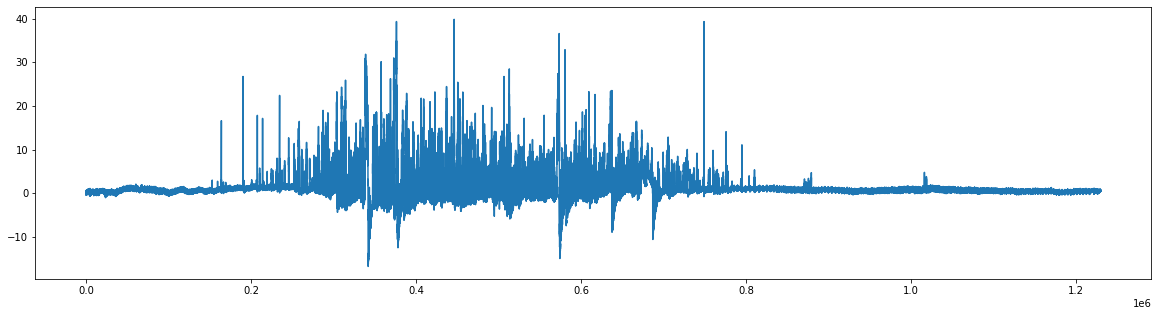

In [226]:
start = 500000
stop = 2000000
process_variance = 1e-3
estimated_measurement_variance = 10000
P0 = 0
sensor = 3
x0 = BCN_signals.iloc[start,sensor]

kf = \
    KalmanFilter1D(
        process_variance,
        estimated_measurement_variance,
        x0,
        P0
    )
series = []
measurements = BCN_signals.iloc[start:stop,sensor].values
inputs = \
    (bottom_temperature_data - bottom_temperature_data.shift(1)).iloc[start-1:stop-1].values

for i in range(len(measurements)):
    kf.input_latest_noisy_measurement(
        measurements[i],
        inputs[i],
        1-1e-6,
        13.15*1e-1
    )
    series.append(kf.get_latest_estimated_measurement()[0])

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 0
plt.plot(BCN_signals.iloc[start+start_series:stop,sensor].values)
plt.plot(series[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(BCN_signals.iloc[start+start_series:stop,sensor].values - series[start_series:])
plt.show()

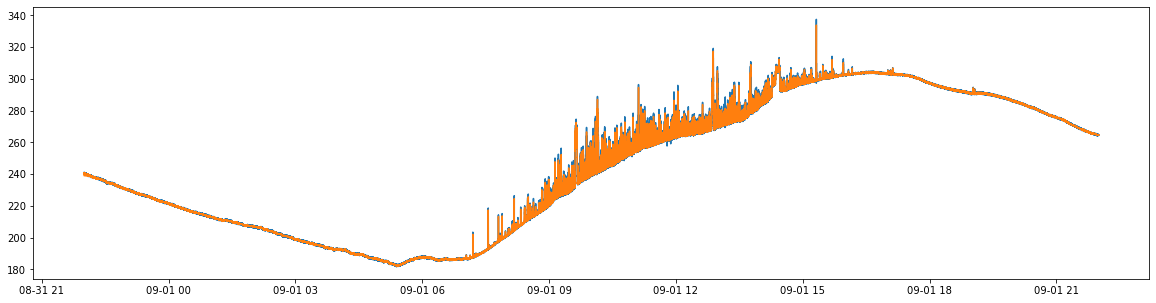

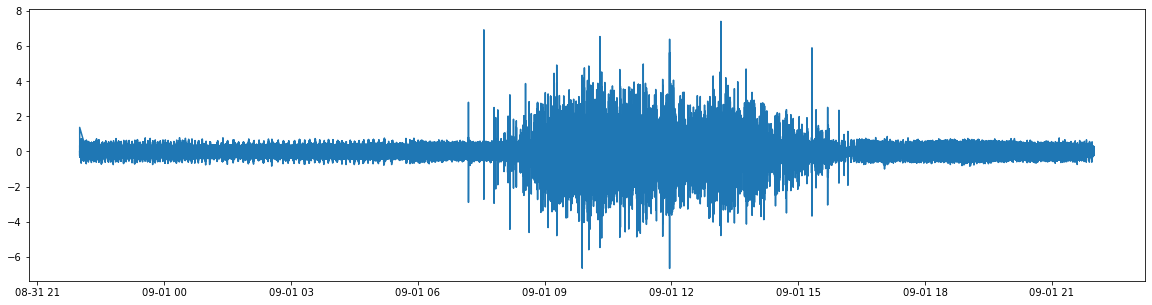

In [54]:
start = 0
stop = 5000000

Q = 1e-4
R = 1e-3
x0 = BCN_signals.iloc[start,3]
P0 = 0

kf = \
    KalmanFilter1D(
        Q,
        R,
        posteri_estimate=x0,
        posteri_error_estimate=P0)
strain_data = BCN_signals.iloc[start:stop,3]
filtered_data = kf.filter_data(strain_data)
compensated_data = strain_data - filtered_data

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 30000
plt.plot(strain_data)
plt.plot(filtered_data)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(compensated_data)
plt.show()

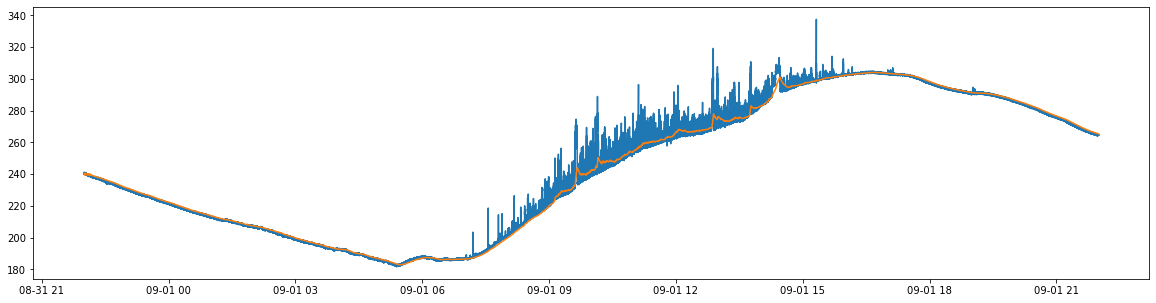

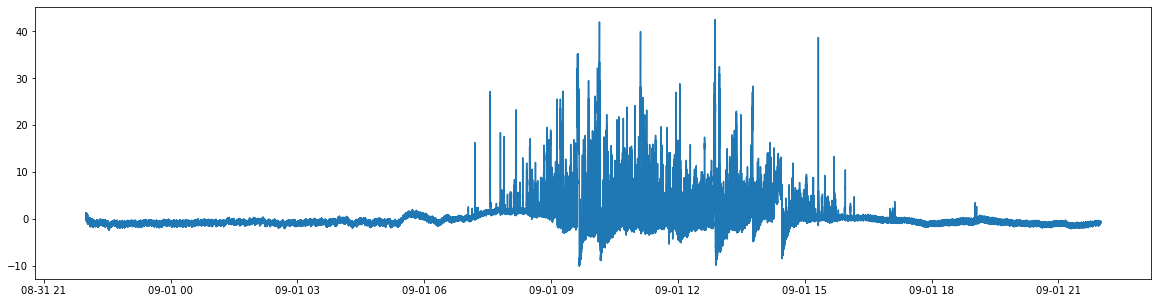

In [53]:
start = 0
stop = 5000000

Q = 1e-4
R = 5000
x0 = BCN_signals.iloc[start,3]
P0 = 0

kf = \
    KalmanFilter1D(
        Q,
        R,
        posteri_estimate=x0,
        posteri_error_estimate=P0)
strain_data = BCN_signals.iloc[start:stop,3]
filtered_data = kf.filter_data(strain_data)
compensated_data = strain_data - filtered_data

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 30000
plt.plot(strain_data)
plt.plot(filtered_data)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(compensated_data)
plt.show()